## Wine Quality Prediction

**Purpose:** This notebook aims to model wine quality based on physicochemical tests.

**Author:** José Maria Trindade

**Data source:** Two datasets are included, related to red and white vinho verde wine samples, from the wine area of Portugal. The target column measures quality 1-9 https://archive.ics.uci.edu/dataset/186/wine+quality

Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

**Input variables** (based on physicochemical tests):
1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

**Output variable** (based on sensory data):

12. quality (score between 0 and 10)

**Missing Attribute Values**: None

### Import section

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Pipeline
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Model savin
import pickle

import warnings
warnings.filterwarnings("ignore")

### Data Loading

In [2]:
df_red = pd.read_csv("winequality-red.csv", sep=";")
df_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df_white = pd.read_csv("winequality-white.csv", sep=";")
df_white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
df_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
df_white.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


First conclusions:
- There are 3 times more white wines than red wines in the dataset
- Both the 11 features and the target column are numerical
- As stated in the initial markdown, there are no NaN values acroos the dataset

Let us concatenate both dataframes while creating a column that mentions the wine type. This will make our analysis easier to do and to follow

In [6]:
df_red["type"] = "red"
df_white["type"] = "white"
df = pd.concat([df_red, df_white], ignore_index=True)
cols_order = [12] + [i for i in range(12)]
df = df.iloc[:, cols_order]

In [7]:
df.sample(5)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1239,red,6.5,0.670,0.00,4.3,0.057,11.0,20.0,0.99488,3.45,0.56,11.8,4
1687,white,7.1,0.430,0.61,11.8,0.045,54.0,155.0,0.99740,3.11,0.45,8.7,5
3494,white,7.9,0.260,0.33,10.3,0.039,73.0,212.0,0.99690,2.93,0.49,9.5,6
542,red,9.3,0.715,0.24,2.1,0.070,5.0,20.0,0.99660,3.12,0.59,9.9,5
1795,white,6.4,0.290,0.44,3.6,0.197,75.0,183.0,0.99420,3.01,0.38,9.1,5


In [8]:
# Correcting the data type of our target column to be ordered categorical
df["quality"] = pd.Categorical(df["quality"], categories=[i+1 for i in range(10)], ordered=True)

In [9]:
# Duplicates
df[df.duplicated(keep=False)].groupby("type").count()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
type,,,,,,,,,,,,
red,460,460,460,460,460,460,460,460,460,460,460,460
white,1709,1709,1709,1709,1709,1709,1709,1709,1709,1709,1709,1709


There are a lot of duplicate records, and there are more in the white-type than in the red-type, but this was already expected.
Nonethless, we are confident that the duplicated data points are not errors, so we should be careful when considering removing duplicates.
- Keeping duplicates can provide a more accurate representation of the distribution of wine characteristics and quality ratings.
Rationale: This ensures that your summary statistics, such as mean, median, and mode, reflect the true frequency of each wine type.
- On one side, if the goal is to predict wine quality based on its characteristics, duplicates may help reinforce patterns in the data, especially for algorithms that benefit from more data (e.g., neural networks). On the other, Duplicates might cause models to overfit.


Decision: let's keep the duplicates for now, and go back to it once we have the evaluation metrics.

In [10]:
df.groupby("type")[df.columns.tolist()[1:-1]].mean()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
type,,,,,,,,,,,
red,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983
white,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267


From the table above we can easily verify that the differences in features between the two types of the wine.
As such, if the project goal was to classify the type of wine, we are confident we would get good results.
However, that would be a project without business value, as it is super easy to detect the type of wine with your own eyes.
Let's focus on the quality classification prediction model.

## EDA
Let us perform exploratory data analysis on our wine dataset, and see if we can find interesting insights that could be used for feature engineering and therefore impacting the performance of the model.

#### Target - "quality"

In [11]:
counts = df["quality"].value_counts()
counts_df = pd.DataFrame(counts)
counts_df["perc"] = (counts_df["count"]/len(df)*100).round(2)
counts_df

,count,perc
quality,,
6,2836,43.65
5,2138,32.91
7,1079,16.61
4,216,3.32
8,193,2.97
3,30,0.46
9,5,0.08
1,0,0.00
2,0,0.00


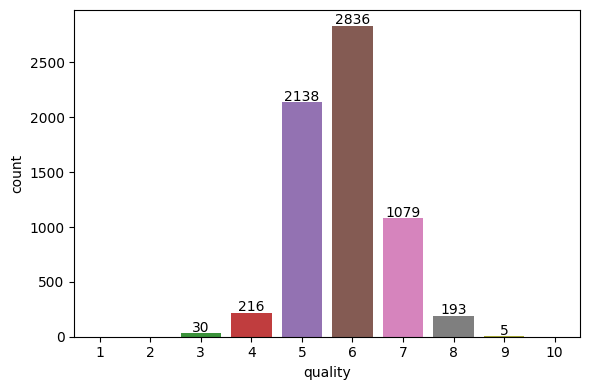

In [12]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x="quality", data=df, hue="quality",dodge=False, legend=False)

# Add count values on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 4), 
                textcoords = 'offset points')

plt.tight_layout()
plt.show()

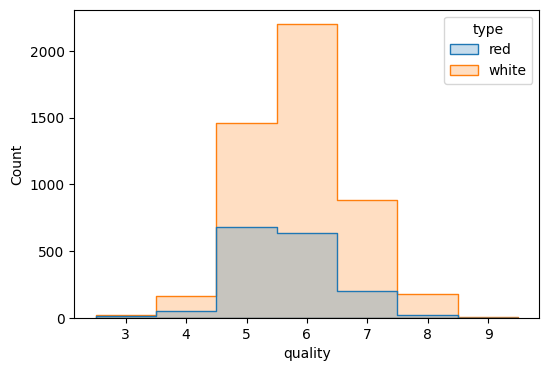

In [13]:
plt.figure(figsize=(6,4))
sns.histplot(data=df, x="quality", hue="type", element="step", binwidth=1)
plt.show()

As we can see from the table, the bar chart, and the histogram, that the classes are very much imbalaced towards "moderate-quality" wines, and therefore one can expect that there will be a natural bias from the model to predict these classes.

Even though the labels are not continuous, I used the histogram because it makes it more visual appealing to compare the distribution of our target across the type of wine, in comparison to a bar chart.

In [14]:
numerical_features = list(df.select_dtypes(include=['int', 'float']).columns)

summary_stats = df.groupby('quality', observed=True)[numerical_features].mean()
summary_stats

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,
3,7.853333,0.517000,0.281000,5.140000,0.077033,39.216667,122.033333,0.995744,3.257667,0.506333,10.215000
4,7.288889,0.457963,0.272315,4.153704,0.060056,20.636574,103.432870,0.994833,3.231620,0.505648,10.180093
5,7.326801,0.389614,0.307722,5.804116,0.064666,30.237371,120.839102,0.995849,3.212189,0.526403,9.837783
6,7.177257,0.313863,0.323583,5.549753,0.054157,31.165021,115.410790,0.994558,3.217726,0.532549,10.587553
7,7.128962,0.288800,0.334764,4.731696,0.045272,30.422150,108.498610,0.993126,3.228072,0.547025,11.386006
8,6.835233,0.291010,0.332539,5.382902,0.041124,34.533679,117.518135,0.992514,3.223212,0.512487,11.678756
9,7.420000,0.298000,0.386000,4.120000,0.027400,33.400000,116.000000,0.991460,3.308000,0.466000,12.180000


Despite being a wine lover, I do not have domain expertise in wine quality, and therefore I cannot confidently say that there is a certain feature that shifts the wine quality score up or down.

Let us do more EDA on the input variables.

#### Inputs

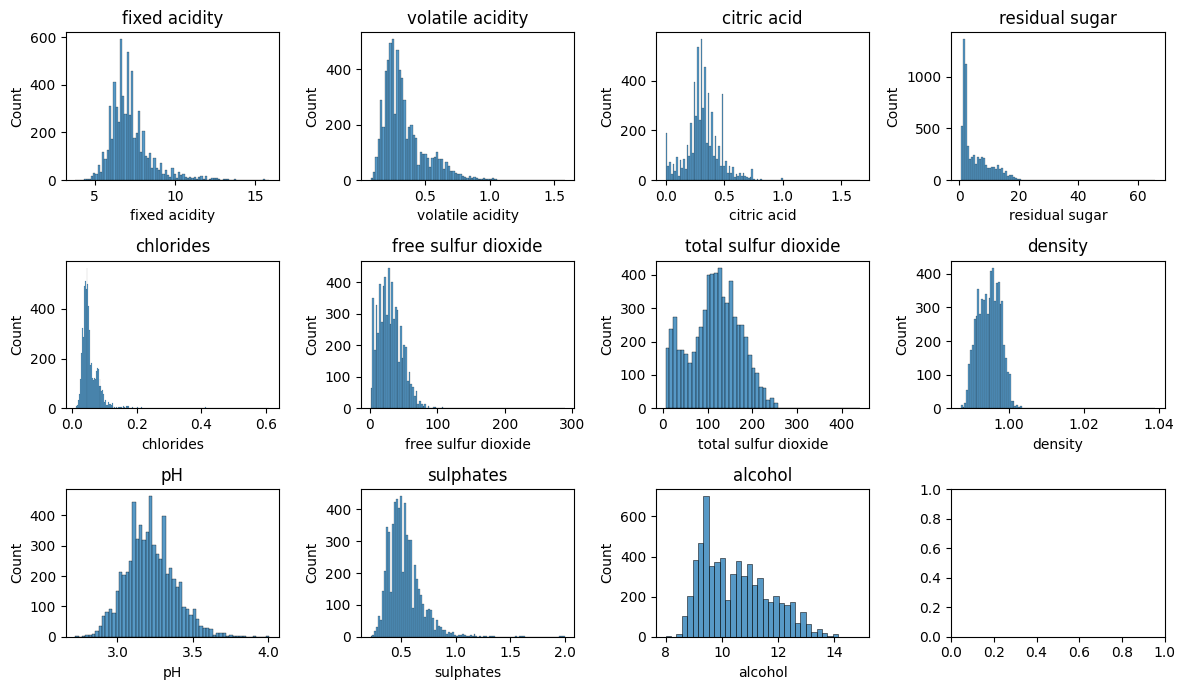

In [15]:
fig, axes = plt.subplots(3,4, figsize=(12,7))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.histplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(col)
    
plt.tight_layout()
plt.show()

**Observations and suggestions for feature engineering**
1. Skewed Distributions:
Features like volatile acidity, residual sugar, chlorides, free sulfur dioxide, and total sulfur dioxide are highly skewed.

Such skewed distributions might require transformations to normalize them, depending on the machine learning algorithms you plan to use.
Many machine learning algorithms assume that the data follows a normal distribution. Reducing skewness can help meet this assumption, leading to better model performance and more accurate predictions.
Common transformations include logarithmic (np.log1p), square root, or Box-Cox transformations.
For example, df['volatile acidity'] = np.log1p(df['volatile acidity']

**!** Running the models before and after transformation could be considerate for analysis

2. Outliers:
There appear to be outliers in several features, particularly in residual sugar, free sulfur dioxide, total sulfur dioxide, and alcohol.

Outliers can disproportionately affect the training process, especially for models sensitive to extreme values like linear regression and k-NN. Removing or capping outliers ensures they do not distort the model’s parameters or predictions. This reduces the risk of overfitting to anomalous data points. Consider applying outliers drop, mean insertion, capping methods

**!** Run the models before and after outliers handling

3. Different Ranges:
Features have different ranges, for example, density is tightly clustered around 1, whereas residual sugar ranges broadly up to about 60.

Features with larger scales can dominate the learning process, causing models to be biased towards these features. Scaling ensures all features contribute equally to the model. For gradient-based algorithms like gradient descent, scaling features can significantly improve the convergence speed by ensuring the gradients are more balanced.
Standardize features to have zero mean and unit variance or normalize them to a range (e.g., 0 to 1).

**!** Scale the features on the train-test split stage

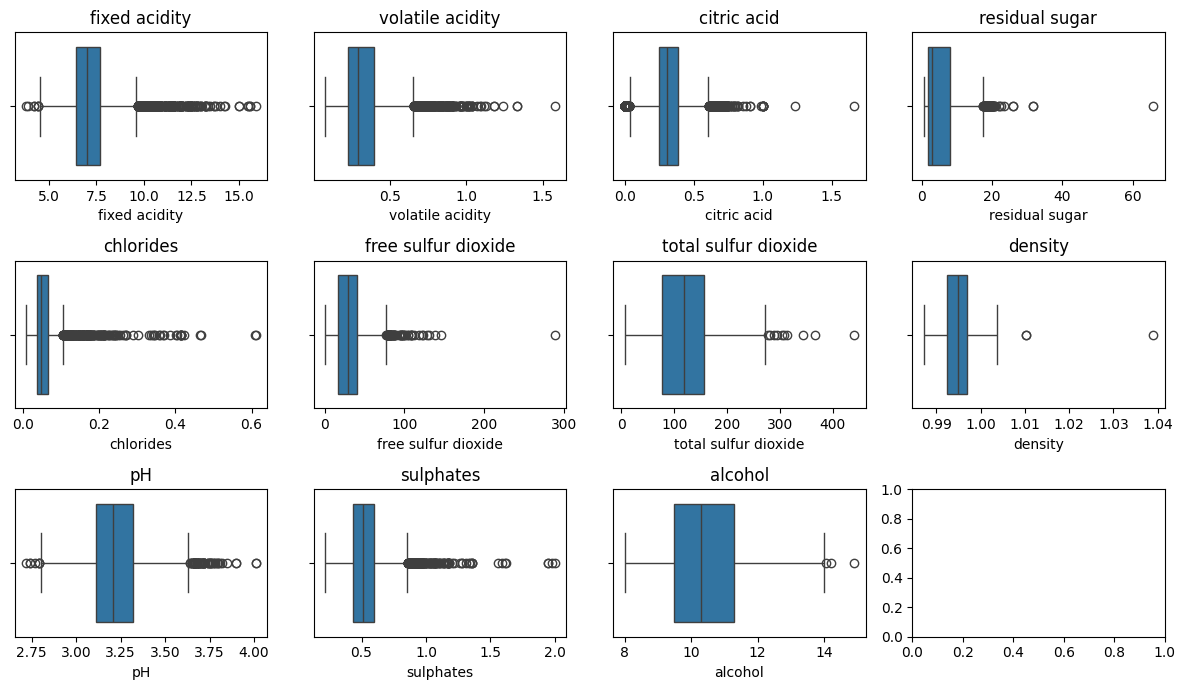

In [16]:
fig, axes = plt.subplots(3,4, figsize=(12,7))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.boxplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(col)
    
plt.tight_layout()
plt.show()

Apart from Alchool and density, we can see that all remaining features have a considerate amount of outliers.
How many?

In [17]:
# Printing the number of Outliers per feature
for col in numerical_features:
    q3 = df[col].quantile(0.75)
    q1 = df[col].quantile(0.25)
    iqr = q3 - q1
    upper_threshold = q3 + 1.5 * iqr
    lower_threshold = q1 - 1.5 * iqr
    df_outliers = df[(df[col]>upper_threshold) | (df[col]<lower_threshold) ]
    print("The feature", col, "has", len(df_outliers),"outliers")

The feature fixed acidity has 357 outliers
The feature volatile acidity has 377 outliers
The feature citric acid has 509 outliers
The feature residual sugar has 118 outliers
The feature chlorides has 286 outliers
The feature free sulfur dioxide has 62 outliers
The feature total sulfur dioxide has 10 outliers
The feature density has 3 outliers
The feature pH has 73 outliers
The feature sulphates has 191 outliers
The feature alcohol has 3 outliers


In [18]:
# Building a df without Outliers
df_wo_outliers = df
for col in numerical_features:
    q3 = df[col].quantile(0.75)
    q1 = df[col].quantile(0.25)
    iqr = q3 - q1
    upper_threshold = q3 + 1.5 * iqr
    lower_threshold = q1 - 1.5 * iqr
    df_wo_outliers = df_wo_outliers[(df_wo_outliers[col]<upper_threshold) & (df_wo_outliers[col]>lower_threshold)]

In [19]:
df_wo_outliers.shape

(5018, 13)

We can see that we removed more than 1400 rows by dropping outliers

## Feature Engineering

Does using a Correlation matrix make sense in our dataset? **No.**

1. Nature of Data: Correlation matrices are designed for continuous data and measure linear relationships, which might not apply when dealing with categorical targets.

2. Categorical Targets: The correlation between continuous features and a categorical target doesn't provide meaningful insights, as the target's categories are not on a continuous scale.

Use instead:
1. ANOVA (Analysis of Variance): This method tests whether there are statistically significant differences between the means of the continuous feature across the categories of the categorical target.
2. Box Plots: Visualize the distribution of continuous features across different categories of the target variable to see if there are noticeable differences.
3. Chi-Square Test: For categorical features, the chi-square test can determine if there is a significant association between the feature and the target.

#### ANOVA for Numerical features
Let us figure out what numerical features we should include in the final model

In [20]:
# Printing the features that do not have statistically significance and therefore should be removed from the model
anova_results = {}
for col in numerical_features:
    anova_results[col] = stats.f_oneway(*[df[col][df['quality'] == quality] for quality in df['quality'].unique()])

anova_results = pd.DataFrame.from_dict(anova_results, orient='index', columns=['F-Statistic', 'p-value'])

print("Numerical Features to remove:", anova_results[anova_results["p-value"]>0.05].index.tolist())

Numerical Features to remove: ['pH']


In [21]:
numerical_features.remove("pH")

Conclusion: All numerical features except "pH"

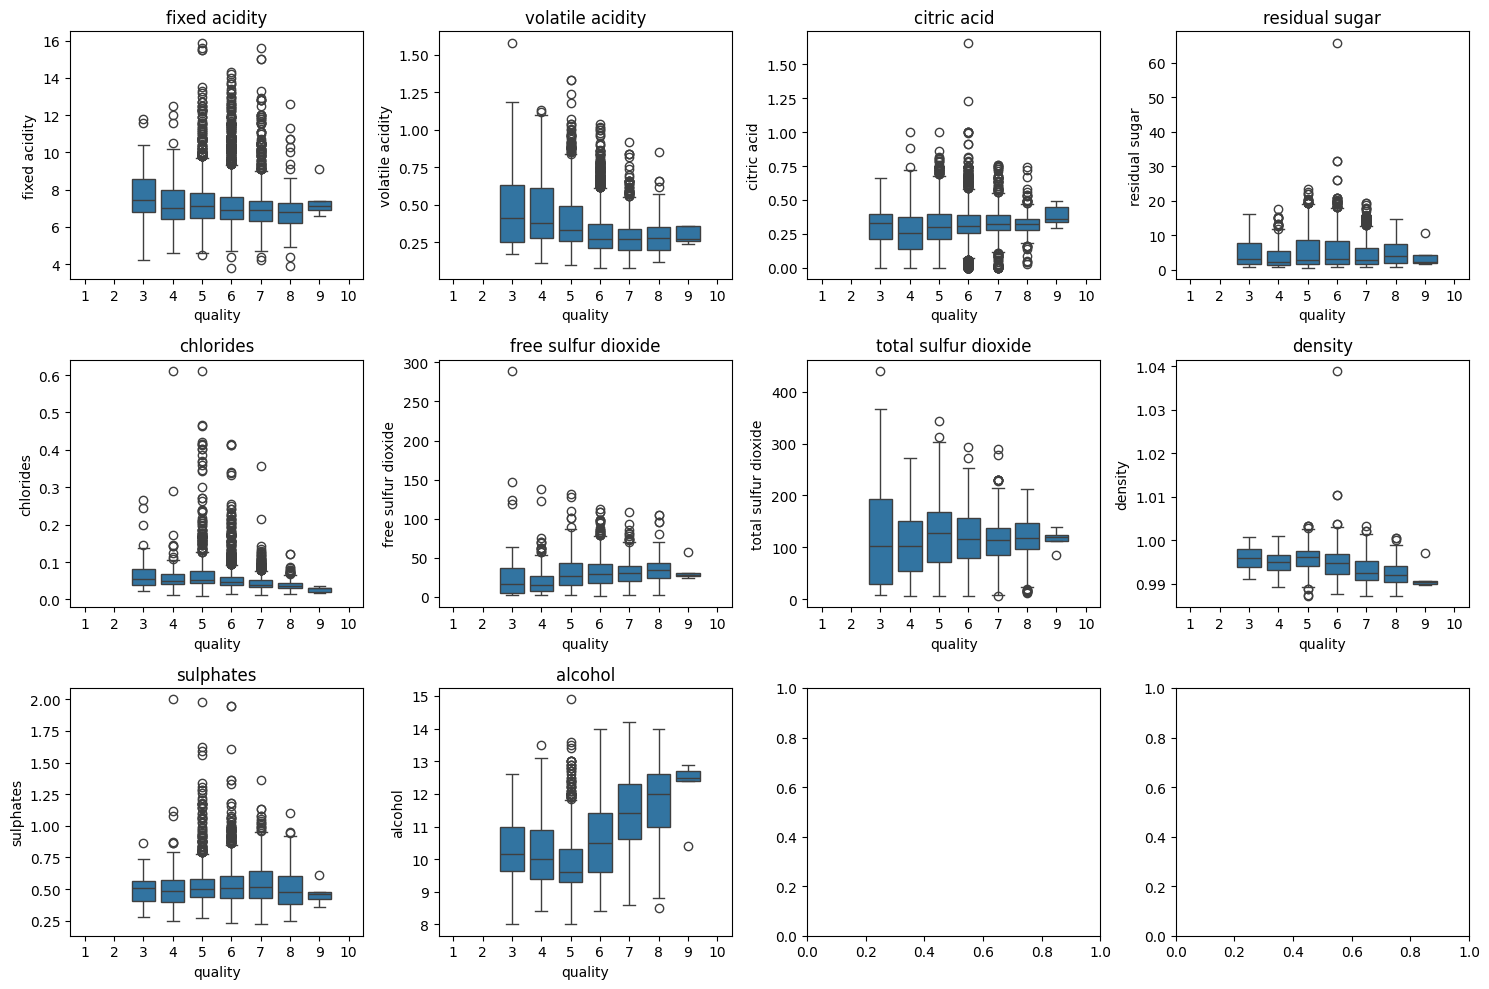

In [22]:
fig, ax = plt.subplots(3, 4, figsize=(15, 10))
ax = ax.flatten()
for i, col in enumerate(numerical_features):
    sns.boxplot(x='quality', y=col, data=df, ax=ax[i])
    ax[i].set_title(col)
plt.tight_layout()
plt.show()

**Variability:** Some features, like volatile acidity and chlorides, show a more distinct pattern with quality, while others, like total sulfur dioxide, show a lot of variability without a clear trend.

**Feature Importance:** Features showing a clear trend with quality (like volatile acidity, chlorides, and alcohol) might be more important predictors of wine quality.

#### Chi-Square Test on the categorial feature "quality"

In [23]:
contingency_table = pd.crosstab(df['type'], df['quality'])

chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi2 Statistic: {chi2}")
print(f"P-value: {p}")

Chi2 Statistic: 116.54327959374594
P-value: 8.66434779598271e-23


There is a significant association between 'type' and 'quality'. Thefore let's include this feature in the model

#### Creating a binary column for the type feature

In [24]:
df = pd.get_dummies(data=df, columns=["type"], drop_first=True) # dropping one of the dummy variables to avoid multicollinearity
df_wo_outliers = pd.get_dummies(data=df_wo_outliers, columns=["type"], drop_first=True) # dropping one of the dummy variables to avoid multicollinearity
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,False
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,False
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,False
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,False
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,False


#### Train-Test split

In [25]:
# Keeping a copy of the df_wo_outliers
df_wo_outliers_copy = df_wo_outliers.copy()

In [26]:
# Let's keep random 300 records out of the 2 dfs, so we can use it for testing
np.random.seed(0)
df_sample = df.sample(300)
df_sample.to_csv("test_wine_dataset0.csv", index=False)
df.drop(df_sample.index, inplace=True)

df_wo_outliers_sample = df_wo_outliers.sample(300)
df_wo_outliers_sample.to_csv("test_wine_dataset1.csv", index=False)
df_wo_outliers.drop(df_wo_outliers_sample.index, inplace=True)

In [27]:
X = df.drop(["pH","quality"], axis=1) # Set of features
y = df["quality"] # Target variable

In [28]:
# Split training and test - test size: 30% random state = 0
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.3, random_state=0)

#### Normalization vs Standardization
Normalization and standardization are two techniques used to transform data into a common scale. 

Normalization is a technique used to scale numerical data in the range of 0 to 1. This technique is useful when the distribution of the data is not known or when the data is not normally distributed. It’s often used when the algorithm does not assume any distribution of the data (e.g., K-Nearest Neighbors, Neural Networks). Can be heavily affected by outliers because it scales the data based on the minimum and maximum values.

On the other hand, standardization is a technique used to transform data into a standard normal distribution. This technique is useful when the distribution of the data is known and when the data is normally distributed. It’s often used when the algorithm assumes a Gaussian distribution of the data (e.g., Linear Regression, Logistic Regression, Support Vector Machines). It is less affected by outliers but still can be influenced if there are extreme values.

- Given that the distribution of the majority of our features are skewed, we will use first Standardization technique for starters with cross-validation to see which preprocessing method yields better model performance.

In [29]:
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

# Choose cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#### final test of Feature Importance with RandomForest

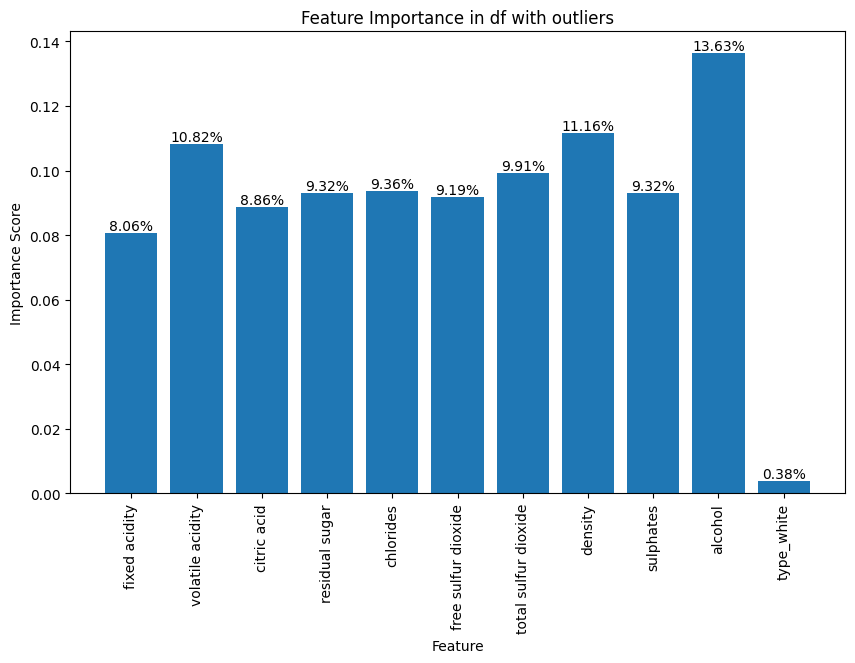

In [30]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(Xtrain_scaled, ytrain)
feature_names = scaler.get_feature_names_out()

# Step 4: Retrieve feature importance scores
feature_importance = model.feature_importances_

# Calculate total sum of feature importance scores
total_importance = sum(feature_importance)

# Visualize feature importance with percentage values on top of bars
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(feature_importance)), feature_importance, align='center')
plt.xticks(range(len(feature_importance)), feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Feature Importance in df with outliers')

# Annotate bars with percentage values
for bar, importance in zip(bars, feature_importance):
    percentage = (importance / total_importance) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage:.2f}%', ha='center', va='bottom')

plt.show()

Contradiction results with "pH":
- p-value: For "pH," if the p-value suggests insignificance, it means that independently, "pH" might not have a strong statistical relationship with the target.
- Feature Importance: A high importance score for "pH" in RandomForest suggests it contributes significantly to the model’s predictive performance.

Evaluate your model's performance with and without the "pH" feature. If the performance drops significantly when "pH" is removed, it indicates that "pH" is valuable for predictions.

When faced with contradictory results between p-values and feature importance, it's essential to consider the context and goals of your analysis. For predictive accuracy, model-based importance might take precedence, while for statistical analysis and interpretability, p-values are crucial. A combined approach often provides the best insights.

## Modelling

In [31]:
train_results_df = pd.DataFrame()
test_results_df = pd.DataFrame()

#### 1 - Trying default models on the whole df 

In [35]:
models = [
    ("Naive Bayes", GaussianNB()),
    ('Logistic Regression', LogisticRegression(random_state=42,max_iter=1000)),
    ('SCV', SVC(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("Neural Network", MLPClassifier(random_state=42,max_iter=1000)),
    ("KNeigh", KNeighborsClassifier())]
    
results_train_dict = {}
results_test_dict = {}

for name, model in models:
    print("\nModel:", name,"\n")

    # Results on Training
    print("Results on TRAIN SET w CROSS-VALIDATION")

    cv_accuracy_scores = cross_val_score(model, Xtrain_scaled, ytrain, cv=kf, scoring='accuracy')
    print(f'Mean CV Accuracy: {cv_accuracy_scores.mean()}')
    results_train_dict[name] = cv_accuracy_scores.mean()

    # Results on Test
    print("\nResults on TEST SET")
    model.fit(Xtrain_scaled, ytrain)
    y_pred = model.predict(Xtest_scaled)

    accuracy = accuracy_score(ytest, y_pred)
    
    print(f'Accuracy: {accuracy}')

    results_test_dict[name] = accuracy
    print()

# Assigning the results to both dfs
results_train_dict = {"With Outliers and Standardization":results_train_dict}
results_test_dict = {"With Outliers and Standardization" : results_test_dict}

temp_results_train_df = pd.DataFrame.from_dict(results_train_dict).transpose()
temp_results_test_df = pd.DataFrame.from_dict(results_test_dict).transpose()

train_results_df = pd.concat([train_results_df , temp_results_train_df], axis=0)
test_results_df = pd.concat([test_results_df , temp_results_test_df], axis=0)



Model: Naive Bayes 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.4261027750758748

Results on TEST SET
Accuracy: 0.3913978494623656


Model: Logistic Regression 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.5517673103396957

Results on TEST SET
Accuracy: 0.5091397849462366


Model: SCV 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.57966716098204

Results on TEST SET
Accuracy: 0.5440860215053763


Model: Decision Tree 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.5681328698462307

Results on TEST SET
Accuracy: 0.5865591397849462


Model: Random Forest 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.6622079951525203

Results on TEST SET
Accuracy: 0.6446236559139785


Model: Gradient Boosting 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.5898104592880796

Results on TEST SET
Accuracy: 0.5591397849462365


Model: Neural Network 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.5792047

In [36]:
train_results_df

,Naive Bayes,Logistic Regression,SCV,Decision Tree,Random Forest,Gradient Boosting,Neural Network,KNeigh
With Outliers and Standardization,0.426103,0.551767,0.579667,0.568133,0.662208,0.58981,0.579205,0.556607


In [37]:
test_results_df

,Naive Bayes,Logistic Regression,SCV,Decision Tree,Random Forest,Gradient Boosting,Neural Network,KNeigh
With Outliers and Standardization,0.391398,0.50914,0.544086,0.586559,0.644624,0.55914,0.555914,0.533333


Conclusions from first iteration:
1. The accuracy is low across all models ≈ 50-58%
2. The best model with default parameters was the Random Forest Classifier - 65%
3. The worst model was Naive Bayes classifier

Next steps: 
- Conclude if pH should be included: Run the same iteration but now considering the pH as a feature and use the best performing model: Random Forest Classifier
- Run the same iteration without outliers

In [38]:
# Trying the Random Forest with pH included

X = df.drop(["quality"], axis=1) # Set of features
y = df["quality"] # Target variable

# Split training and test - test size: 30% random state = 0
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.3, random_state=0)

scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

# Choose cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = [
    ("Random Forest", RandomForestClassifier())]
    
for name, model in models:
    print("\nModel:", name,"\n")
    cv_accuracy_scores = cross_val_score(model, Xtrain_scaled, ytrain, cv=kf, scoring='accuracy')
    print("EVALUATING THE MODEL WITH CROSS-VALIDATION")
    print(f'Mean CV Accuracy: {cv_accuracy_scores.mean()}')

    model.fit(Xtrain_scaled, ytrain)
    y_pred = model.predict(Xtest_scaled)

    # Evaluate the model on the test set
    print("\nEVALUATING THE MODEL ON THE TEST SET")
    accuracy = accuracy_score(ytest, y_pred)
    conf_matrix = confusion_matrix(ytest, y_pred)
    
    print(f'Accuracy: {accuracy}')


Model: Random Forest 

EVALUATING THE MODEL WITH CROSS-VALIDATION
Mean CV Accuracy: 0.6629024285235916

EVALUATING THE MODEL ON THE TEST SET
Accuracy: 0.6521505376344086


We can see that we achieved very similar results when including the pH feature.
With this in mind, and given that we have proved that independently, "pH" might not have a strong statistical relationship with the target, **we will remove the pH feature from the model.**

Next step: run the first iteration with the df where we excluded the outliers

#### 2- Running the models on the df without outliers

In [39]:
# Runing the models on the df without outliers

X = df_wo_outliers.drop(["pH","quality"], axis=1) # Set of features
y = df_wo_outliers["quality"] # Target variable

# Split training and test - test size: 30% random state = 0
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.3, random_state=0)

scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

# Choose cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = [
    ("Naive Bayes", GaussianNB()),
    ('Logistic Regression', LogisticRegression(random_state=42,max_iter=1000)),
    ('SCV', SVC(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("Neural Network", MLPClassifier(random_state=42,max_iter=1000)),
    ("KNeigh", KNeighborsClassifier())]
    
results_train_dict = {}
results_test_dict = {}

for name, model in models:
    print("\nModel:", name,"\n")

    # Results on Training
    print("Results on TRAIN SET w CROSS-VALIDATION")

    cv_accuracy_scores = cross_val_score(model, Xtrain_scaled, ytrain, cv=kf, scoring='accuracy')
    print(f'Mean CV Accuracy: {cv_accuracy_scores.mean()}')
    results_train_dict[name] = cv_accuracy_scores.mean()

    # Results on Test
    print("\nResults on TEST SET")
    model.fit(Xtrain_scaled, ytrain)
    y_pred = model.predict(Xtest_scaled)

    accuracy = accuracy_score(ytest, y_pred)
    
    print(f'Accuracy: {accuracy}')

    results_test_dict[name] = accuracy
    print()

# Assigning the results to both dfs
results_train_dict = {"Without Outliers and Standardization":results_train_dict}
results_test_dict = {"Without Outliers and Standardization" : results_test_dict}

temp_results_train_df = pd.DataFrame.from_dict(results_train_dict).transpose()
temp_results_test_df = pd.DataFrame.from_dict(results_test_dict).transpose()

train_results_df = pd.concat([train_results_df , temp_results_train_df], axis=0)
test_results_df = pd.concat([test_results_df , temp_results_test_df], axis=0)


Model: Naive Bayes 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.143553844037959

Results on TEST SET
Accuracy: 0.10240112994350282


Model: Logistic Regression 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.5312098290010544

Results on TEST SET
Accuracy: 0.5346045197740112


Model: SCV 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.5636038142392151

Results on TEST SET
Accuracy: 0.5586158192090396


Model: Decision Tree 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.541790216843167

Results on TEST SET
Accuracy: 0.5819209039548022


Model: Random Forest 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.6362820336496584

Results on TEST SET
Accuracy: 0.6680790960451978


Model: Gradient Boosting 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.5763219181222207

Results on TEST SET
Accuracy: 0.5861581920903954


Model: Neural Network 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.554216

In [40]:
train_results_df

,Naive Bayes,Logistic Regression,SCV,Decision Tree,Random Forest,Gradient Boosting,Neural Network,KNeigh
With Outliers and Standardization,0.426103,0.551767,0.579667,0.568133,0.662208,0.589810,0.579205,0.556607
Without Outliers and Standardization,0.143554,0.531210,0.563604,0.541790,0.636282,0.576322,0.554217,0.529076


In [41]:
test_results_df

,Naive Bayes,Logistic Regression,SCV,Decision Tree,Random Forest,Gradient Boosting,Neural Network,KNeigh
With Outliers and Standardization,0.391398,0.509140,0.544086,0.586559,0.644624,0.559140,0.555914,0.533333
Without Outliers and Standardization,0.102401,0.534605,0.558616,0.581921,0.668079,0.586158,0.582627,0.545198


Conclusion:

We have seen improvements in accuracy in most of the models, but overall the metric is still scoring very low. Let's check the confusion matrix for the best model (RandomForestClassifier) to **look for class imbalance.**

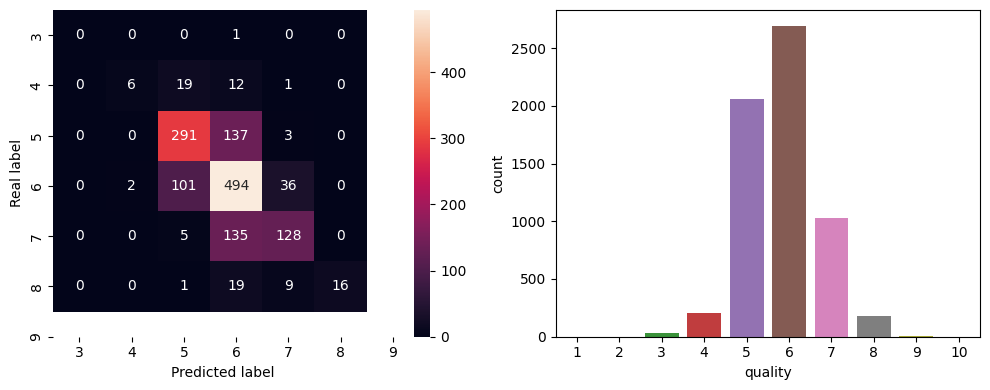

In [42]:
model = RandomForestClassifier()
model.fit(Xtrain_scaled, ytrain)
y_pred = model.predict(Xtest_scaled)

conf_matrix = confusion_matrix(ytest, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax = ax.flatten()


sns.heatmap(conf_matrix,annot=True,fmt='', xticklabels=sorted(df_wo_outliers.quality.unique()),
            yticklabels=sorted(df_wo_outliers.quality.unique()), ax=ax[0])
ax[0].set_ylabel("Real label")
ax[0].set_xlabel("Predicted label")

sns.countplot(x="quality", data=df, hue="quality",dodge=False, legend=False, ax=ax[1])

plt.tight_layout()
plt.show()

In [43]:
print(classification_report(ytest, y_pred, labels=sorted(df_wo_outliers.quality.unique())))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.75      0.16      0.26        38
           5       0.70      0.68      0.69       431
           6       0.62      0.78      0.69       633
           7       0.72      0.48      0.58       268
           8       1.00      0.36      0.52        45
           9       0.00      0.00      0.00         0

   micro avg       0.66      0.66      0.66      1416
   macro avg       0.54      0.35      0.39      1416
weighted avg       0.68      0.66      0.65      1416



/Users/zemariatrindade/BTS/Classical_Data_Analysis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/zemariatrindade/BTS/Classical_Data_Analysis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/zemariatrindade/BTS/Classical_Data_Analysis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control thi

As we can see, **having imbalanced data is a problem in classification taks** because the biased towards the majority class leads to the majority class dominating the decision boundary, and as a result poor classificiation performance for the minority class.

In addition, it can result in models that generalize poorly to unseen data, especially for the minority class. Since the minority class is underrepresented, the model may not have enough examples to learn the underlying patterns, leading to overfitting to the majority class.

The model performs reasonably well for classes 5, 6, and 7, which are the most frequent classes.

The confusion matrix shows significant misclassifications, particularly for less frequent classes such as 3, 4, 8, and 9.

There are no predictions for class 3 and 9, indicating that the model is struggling with these classes.

The precision, recall, and F1-scores for classes 5, 6, and 7 are relatively high.

The scores for other classes, especially 3, 4, 8, and 9, are very low, indicating poor performance.



#### 3 - Class Imbalance: Applying SMOTE
Resampling the training set with synthetic data

In [44]:
os = SMOTE(random_state=0,  k_neighbors=2)

# Apply oversampling ONLY ON training data
os_data_X, os_data_y = os.fit_resample(Xtrain_scaled, ytrain)

# Choose cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = [
    ("Naive Bayes", GaussianNB()),
    ('Logistic Regression', LogisticRegression(random_state=42,max_iter=1000)),
    ('SCV', SVC(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("Neural Network", MLPClassifier(random_state=42,max_iter=1000)),
    ("KNeigh", KNeighborsClassifier())]
    
results_train_dict = {}
results_test_dict = {}

for name, model in models:
    print("\nModel:", name,"\n")

    # Results on Training
    print("Results on TRAIN SET w CROSS-VALIDATION")

    cv_accuracy_scores = cross_val_score(model, os_data_X, os_data_y, cv=kf, scoring='accuracy')
    print(f'Mean CV Accuracy: {cv_accuracy_scores.mean()}')
    results_train_dict[name] = cv_accuracy_scores.mean()

    # Results on Test
    print("\nResults on TEST SET")
    model.fit(os_data_X, os_data_y)
    y_pred = model.predict(Xtest_scaled)

    accuracy = accuracy_score(ytest, y_pred)
    
    print(f'Accuracy: {accuracy}')

    results_test_dict[name] = accuracy
    print()

# Assigning the results to both dfs
results_train_dict = {"Without Outliers, Standardization, smote":results_train_dict}
results_test_dict = {"Without Outliers and Standardization, smote" : results_test_dict}

temp_results_train_df = pd.DataFrame.from_dict(results_train_dict).transpose()
temp_results_test_df = pd.DataFrame.from_dict(results_test_dict).transpose()

train_results_df = pd.concat([train_results_df , temp_results_train_df], axis=0)
test_results_df = pd.concat([test_results_df , temp_results_test_df], axis=0)


Model: Naive Bayes 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.313616817964644

Results on TEST SET
Accuracy: 0.0882768361581921


Model: Logistic Regression 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.5010033444816053

Results on TEST SET
Accuracy: 0.3128531073446328


Model: SCV 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.775824175824176

Results on TEST SET
Accuracy: 0.4562146892655367


Model: Decision Tree 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.8364070711896797

Results on TEST SET
Accuracy: 0.548728813559322


Model: Random Forest 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.9015766841853798

Results on TEST SET
Accuracy: 0.6398305084745762


Model: Gradient Boosting 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.8003822264691831

Results on TEST SET
Accuracy: 0.4865819209039548


Model: Neural Network 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.84242713

In [45]:
counts = os_data_y.value_counts()
counts

quality
3     1495
4     1495
5     1495
6     1495
7     1495
8     1495
9     1495
1        0
2        0
10       0
Name: count, dtype: int64

In [46]:
train_results_df

,Naive Bayes,Logistic Regression,SCV,Decision Tree,Random Forest,Gradient Boosting,Neural Network,KNeigh
With Outliers and Standardization,0.426103,0.551767,0.579667,0.568133,0.662208,0.589810,0.579205,0.556607
Without Outliers and Standardization,0.143554,0.531210,0.563604,0.541790,0.636282,0.576322,0.554217,0.529076
"Without Outliers, Standardization, smote",0.313617,0.501003,0.775824,0.836407,0.901577,0.800382,0.842427,0.839943


In [47]:
test_results_df

,Naive Bayes,Logistic Regression,SCV,Decision Tree,Random Forest,Gradient Boosting,Neural Network,KNeigh
With Outliers and Standardization,0.391398,0.509140,0.544086,0.586559,0.644624,0.559140,0.555914,0.533333
Without Outliers and Standardization,0.102401,0.534605,0.558616,0.581921,0.668079,0.586158,0.582627,0.545198
"Without Outliers and Standardization, smote",0.088277,0.312853,0.456215,0.548729,0.639831,0.486582,0.509181,0.481638


We are having good results in training and bad results in testing. 
This is sign of overfitting. It is normal since we get very little date when we apply SMOTE on a very imbalance dataset and significant amount of labels.

We can also explore apllying further regularization.

#### Merging Labels

Given the imbalanced distribution of quality grades in your dataset, merging labels can help improve the model's performance by reducing the number of classes and increasing the number of samples per class.

So, here is the merging labels approach we suggest:
- Merge classes 3, 4, and 5 into a single class called "Low Quality".
- Merge classes 6, 7 into a single class called "Medium Quality".
- Merge classes 8, 9, and 10 into a single class called "High Quality".

In [48]:
# As we are re-labeling the data, we need to use the df_wo_outliers copy because it stores all the data
# after the merging labels and we take out 300 samples and we move it to disk as a csv
df_wo_outliers = df_wo_outliers_copy
df_wo_outliers['quality_merged'] = df_wo_outliers['quality'].apply(lambda x: 'Low Quality' if x in [1,3, 4, 5] else ('Medium Quality' if x in [6,7] else 'High Quality'))
df_wo_outliers["quality_merged"] = pd.Categorical(df_wo_outliers["quality_merged"], categories=['Low Quality', 'Medium Quality', 'High Quality'], ordered=True)

In [49]:
# Splitting the data into features and target variable
X = df_wo_outliers.drop(['pH','quality', 'quality_merged'], axis=1)
y = df_wo_outliers['quality_merged']

In [50]:
y.value_counts()

quality_merged
Medium Quality    3185
Low Quality       1660
High Quality       173
Name: count, dtype: int64

Even with the label merger, we still suffer from class imbalance. The High quality wines are too few in the dataset. Let's use SMOTE for the training dataset 

In [51]:
# Let's keep random 300 records out of the 2 dfs, so we can use it for testing
np.random.seed(0)
df_wo_outliers_sample = df_wo_outliers.sample(300)
df_wo_outliers_sample.to_csv("test_wine_dataset2.csv", index=False)
df_wo_outliers.drop(df_wo_outliers_sample.index, inplace=True)

#### 4 - Applying SMOTE again but now on the merged labels

In [52]:
# Create training and test set - test size: 30%, random_state=0
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=0)

os = SMOTE(random_state=0)

scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

# Apply oversampling ONLY ON training data
os_data_X, os_data_y = os.fit_resample(Xtrain_scaled, ytrain)

# Choose cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = [
    ("Naive Bayes", GaussianNB()),
    ('Logistic Regression', LogisticRegression(random_state=42,max_iter=1000)),
    ('SCV', SVC(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("Neural Network", MLPClassifier(random_state=42,max_iter=1000)),
    ("KNeigh", KNeighborsClassifier())]
    
results_train_dict = {}
results_test_dict = {}

for name, model in models:
    print("\nModel:", name,"\n")

    # Results on Training
    print("Results on TRAIN SET w CROSS-VALIDATION")

    cv_accuracy_scores = cross_val_score(model, os_data_X, os_data_y, cv=kf, scoring='accuracy')
    print(f'Mean CV Accuracy: {cv_accuracy_scores.mean()}')
    results_train_dict[name] = cv_accuracy_scores.mean()

    # Results on Test
    print("\nResults on TEST SET")
    model.fit(os_data_X, os_data_y)
    y_pred = model.predict(Xtest_scaled)

    accuracy = accuracy_score(ytest, y_pred)
    
    print(f'Accuracy: {accuracy}')

    results_test_dict[name] = accuracy
    print()

# Assigning the results to both dfs
results_train_dict = {"without outliers, standardization, smote and 3 labels":results_train_dict}
results_test_dict = {"without outliers, standardization, smote and 3 labels" : results_test_dict}

temp_results_train_df = pd.DataFrame.from_dict(results_train_dict).transpose()
temp_results_test_df = pd.DataFrame.from_dict(results_test_dict).transpose()

train_results_df = pd.concat([train_results_df , temp_results_train_df], axis=0)
test_results_df = pd.concat([test_results_df , temp_results_test_df], axis=0)


Model: Naive Bayes 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.5437519289732343

Results on TEST SET
Accuracy: 0.3253652058432935


Model: Logistic Regression 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.5904268860007794

Results on TEST SET
Accuracy: 0.4953519256308101


Model: SCV 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.7660232625723999

Results on TEST SET
Accuracy: 0.6082337317397079


Model: Decision Tree 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.8126936013282601

Results on TEST SET
Accuracy: 0.701195219123506


Model: Random Forest 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.894191678550268

Results on TEST SET
Accuracy: 0.7828685258964143


Model: Gradient Boosting 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.7994912016292361

Results on TEST SET
Accuracy: 0.6819389110225763


Model: Neural Network 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.8388138

In [53]:
train_results_df

,Naive Bayes,Logistic Regression,SCV,Decision Tree,Random Forest,Gradient Boosting,Neural Network,KNeigh
With Outliers and Standardization,0.426103,0.551767,0.579667,0.568133,0.662208,0.589810,0.579205,0.556607
Without Outliers and Standardization,0.143554,0.531210,0.563604,0.541790,0.636282,0.576322,0.554217,0.529076
"Without Outliers, Standardization, smote",0.313617,0.501003,0.775824,0.836407,0.901577,0.800382,0.842427,0.839943
"without outliers, standardization, smote and 3 labels",0.543752,0.590427,0.766023,0.812694,0.894192,0.799491,0.838814,0.807895


In [54]:
test_results_df

,Naive Bayes,Logistic Regression,SCV,Decision Tree,Random Forest,Gradient Boosting,Neural Network,KNeigh
With Outliers and Standardization,0.391398,0.509140,0.544086,0.586559,0.644624,0.559140,0.555914,0.533333
Without Outliers and Standardization,0.102401,0.534605,0.558616,0.581921,0.668079,0.586158,0.582627,0.545198
"Without Outliers and Standardization, smote",0.088277,0.312853,0.456215,0.548729,0.639831,0.486582,0.509181,0.481638
"without outliers, standardization, smote and 3 labels",0.325365,0.495352,0.608234,0.701195,0.782869,0.681939,0.704515,0.616866


Good! Best model so far: Random Forest

Ok, now we increased a lot our accuracy score on the test set to around to 80%, and around 90% on training.

Let's check the confusion matrix and the classification report on the best model

In [55]:
ytest.value_counts()

quality_merged
Medium Quality    964
Low Quality       493
High Quality       49
Name: count, dtype: int64

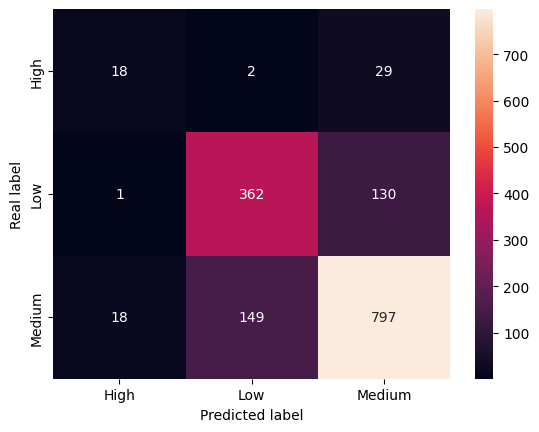

In [56]:
model = RandomForestClassifier()
model.fit(os_data_X, os_data_y)
y_pred = model.predict(Xtest_scaled)

conf_matrix = confusion_matrix(ytest, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='', xticklabels=["High","Low","Medium"],
            yticklabels=["High","Low","Medium"])
plt.ylabel("Real label")
plt.xlabel("Predicted label")

plt.show()

In [57]:
print(classification_report(ytest, y_pred))

                precision    recall  f1-score   support

  High Quality       0.49      0.37      0.42        49
   Low Quality       0.71      0.73      0.72       493
Medium Quality       0.83      0.83      0.83       964

      accuracy                           0.78      1506
     macro avg       0.68      0.64      0.66      1506
  weighted avg       0.78      0.78      0.78      1506



The model is becoming good at predicting Medium and Low Quality, but it is strugling hard with the high quality wine

#### 5- Class Imbalance: Undersample with merged labels
Before we save the best model, let's give a final try with Undersampling the majority class

- Low Quality       200
- Medium Quality    200
- High Quality      173 (maximum possible)

In [58]:
df_wo_outliers.quality_merged.value_counts()

quality_merged
Medium Quality    2984
Low Quality       1574
High Quality       160
Name: count, dtype: int64

In [59]:
sample_medium = df_wo_outliers[df_wo_outliers["quality_merged"] == "Medium Quality"].sample(200)
sample_low = df_wo_outliers[df_wo_outliers["quality_merged"] == "Low Quality"].sample(200)
sample_high = df_wo_outliers[df_wo_outliers["quality_merged"] == "High Quality"]
undersampled_df = pd.concat([sample_high, sample_low, sample_medium], ignore_index=False).sample(len(sample_high))

In [60]:
X = undersampled_df.drop(['pH','quality', 'quality_merged'], axis=1)
y = undersampled_df['quality_merged']

In [61]:
# Split training and test - test size: 30% random state = 0
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.3, random_state=0)

scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

# Choose cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = [
    ("Naive Bayes", GaussianNB()),
    ('Logistic Regression', LogisticRegression(random_state=42,max_iter=1000)),
    ('SCV', SVC(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("Neural Network", MLPClassifier(random_state=42,max_iter=1000)),
    ("KNeigh", KNeighborsClassifier())]
    
results_train_dict = {}
results_test_dict = {}

for name, model in models:
    print("\nModel:", name,"\n")

    # Results on Training
    print("Results on TRAIN SET w CROSS-VALIDATION")

    cv_accuracy_scores = cross_val_score(model, Xtrain_scaled, ytrain, cv=kf, scoring='accuracy')
    print(f'Mean CV Accuracy: {cv_accuracy_scores.mean()}')
    results_train_dict[name] = cv_accuracy_scores.mean()

    # Results on Test
    print("\nResults on TEST SET")
    model.fit(Xtrain_scaled, ytrain)
    y_pred = model.predict(Xtest_scaled)

    accuracy = accuracy_score(ytest, y_pred)
    
    print(f'Accuracy: {accuracy}')

    results_test_dict[name] = accuracy
    print()

# Assigning the results to both dfs
results_train_dict = {"without outliers, standardization, undersampling and 3 labels":results_train_dict}
results_test_dict = {"without outliers, standardization, undersampling and 3 labels" : results_test_dict}

temp_results_train_df = pd.DataFrame.from_dict(results_train_dict).transpose()
temp_results_test_df = pd.DataFrame.from_dict(results_test_dict).transpose()

train_results_df = pd.concat([train_results_df , temp_results_train_df], axis=0)
test_results_df = pd.concat([test_results_df , temp_results_test_df], axis=0)


Model: Naive Bayes 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.4462450592885375

Results on TEST SET
Accuracy: 0.5208333333333334


Model: Logistic Regression 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.5181818181818182

Results on TEST SET
Accuracy: 0.5208333333333334


Model: SCV 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.5185770750988141

Results on TEST SET
Accuracy: 0.5625


Model: Decision Tree 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.4727272727272728

Results on TEST SET
Accuracy: 0.5


Model: Random Forest 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.4727272727272728

Results on TEST SET
Accuracy: 0.6041666666666666


Model: Gradient Boosting 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.46403162055335967

Results on TEST SET
Accuracy: 0.6041666666666666


Model: Neural Network 

Results on TRAIN SET w CROSS-VALIDATION
Mean CV Accuracy: 0.4905138339920949

Results on TE

In [62]:
train_results_df

,Naive Bayes,Logistic Regression,SCV,Decision Tree,Random Forest,Gradient Boosting,Neural Network,KNeigh
With Outliers and Standardization,0.426103,0.551767,0.579667,0.568133,0.662208,0.589810,0.579205,0.556607
Without Outliers and Standardization,0.143554,0.531210,0.563604,0.541790,0.636282,0.576322,0.554217,0.529076
"Without Outliers, Standardization, smote",0.313617,0.501003,0.775824,0.836407,0.901577,0.800382,0.842427,0.839943
"without outliers, standardization, smote and 3 labels",0.543752,0.590427,0.766023,0.812694,0.894192,0.799491,0.838814,0.807895
"without outliers, standardization, undersampling and 3 labels",0.446245,0.518182,0.518577,0.472727,0.472727,0.464032,0.490514,0.437154


In [63]:
test_results_df

,Naive Bayes,Logistic Regression,SCV,Decision Tree,Random Forest,Gradient Boosting,Neural Network,KNeigh
With Outliers and Standardization,0.391398,0.509140,0.544086,0.586559,0.644624,0.559140,0.555914,0.533333
Without Outliers and Standardization,0.102401,0.534605,0.558616,0.581921,0.668079,0.586158,0.582627,0.545198
"Without Outliers and Standardization, smote",0.088277,0.312853,0.456215,0.548729,0.639831,0.486582,0.509181,0.481638
"without outliers, standardization, smote and 3 labels",0.325365,0.495352,0.608234,0.701195,0.782869,0.681939,0.704515,0.616866
"without outliers, standardization, undersampling and 3 labels",0.520833,0.520833,0.562500,0.500000,0.604167,0.604167,0.500000,0.541667


The results were not good for undersampling.

In [64]:
# Saving the scorecards to disk
train_results_df.to_csv("scorecard_train.csv")
test_results_df.to_csv("scorecard_test.csv")

#### Gridsearch on our best model so far
Our best model so far was the Random Forest on df without outliers, using standardization, smote tecnhique and only 3 labels
Let's do GridSearch on the best model and save it to a pickle

In [69]:
# Splitting the data into features and target variable
X = df_wo_outliers.drop(['pH','quality', 'quality_merged'], axis=1)
y = df_wo_outliers['quality_merged']


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define the pipeline
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),    # Step 1: Standardize the features
    ('smote', SMOTE(random_state=42)),  # Step 2: Apply SMOTE
    ('classifier', RandomForestClassifier(random_state=42))  # Step 3: Random Forest Classifier
])

# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200],   # Number of trees in the forest
    'classifier__max_depth': [10, 20],  # Maximum depth of the tree
    'classifier__min_samples_split': [2, 10],  # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': [1, 4],    # Minimum number of samples required to be at a leaf node
    'classifier__max_features': ['sqrt', 'log2']  # Number of features to consider when looking for the best split
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Predict on the test set
y_pred = grid_search.predict(X_test)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, labels=np.unique(y)))

# To get the best model and use it for further predictions
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters found:  {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Confusion Matrix:
 [[ 19   1  28]
 [  1 328 143]
 [ 25 142 729]]
Classification Report:
                 precision    recall  f1-score   support

  High Quality       0.42      0.40      0.41        48
   Low Quality       0.70      0.69      0.70       472
Medium Quality       0.81      0.81      0.81       896

      accuracy                           0.76      1416
     macro avg       0.64      0.63      0.64      1416
  weighted avg       0.76      0.76      0.76      1416

[CV] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   2.3s
[CV] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__mi

**We have our best model!**

Pre Processing:
1. Standardization
2. SMOTE on training dataset

Model: Random Forest Classifier

Best parameters found: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

#### Comments on the best model

Our best model is having a medium high overall accuracy score around 80%.
The model seems to predict very well medium quality wines, moderately low quality wines, and badly good quality wines.

To improve the performance of our model, we need to increase the number of high quality wines, and in an ideal scenario add more features that could capture more complex real relationships with the target.

## Saving the model to a pickle file

In [77]:
# Save the best model
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [80]:
# Testing if it works
# Load the model
with open('best_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

df_test = pd.read_csv("test_wine_dataset2.csv")

# Splitting the data into features and target variable
X = df_test.drop(['pH','quality', 'quality_merged'], axis=1)
y = df_test['quality_merged']

# Predict on the test set using the loaded model
y_pred_loaded_model = loaded_model.predict(X)

accuracy_score(y_pred_loaded_model, y)

0.73

In [81]:
df_test["class"] = y_pred_loaded_model

In [86]:
df_test = df_test["class"].reset_index().rename(columns={"index":"id"})

In [87]:
df_test

,id,class
0,0,Medium Quality
1,1,Medium Quality
2,2,Medium Quality
3,3,Low Quality
4,4,Low Quality
...,...,...
295,295,Medium Quality
296,296,Low Quality
297,297,Medium Quality
298,298,Low Quality
